## Import Library

In [20]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [21]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [22]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

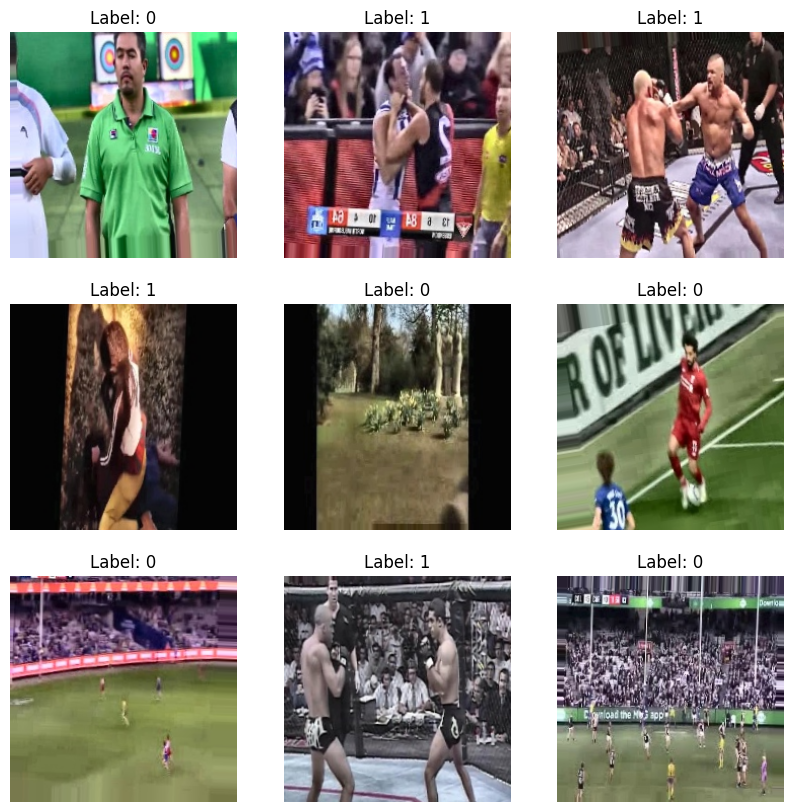

In [23]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [24]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze20_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [25]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6041 - loss: 1.3277
Epoch 1: val_accuracy improved from -inf to 0.52045, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 637ms/step - accuracy: 0.6049 - loss: 1.3257 - val_accuracy: 0.5205 - val_loss: 1.1373
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7231 - loss: 1.1398
Epoch 2: val_accuracy improved from 0.52045 to 0.61591, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 613ms/step - accuracy: 0.7235 - loss: 1.1386 - val_accuracy: 0.6159 - val_loss: 1.0565
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.7430 - loss: 1.0135
Epoch 3: val_accuracy improved from 0.61591 to 0.73864, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 586ms/step - accuracy: 0.7432 - loss: 1.0128 - val_accuracy: 0.7386 - val_loss: 0.9834
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7680 - loss: 0.9462
Epoch 4: val_accuracy improved from 0.73864 to 0.84318, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 586ms/step - accuracy: 0.7681 - loss: 0.9460 - val_accuracy: 0.8432 - val_loss: 0.8977
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7682 - loss: 0.8976
Epoch 5: val_accuracy improved from 0.84318 to 0.87045, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 578ms/step - accuracy: 0.7685 - loss: 0.8973 - val_accuracy: 0.8705 - val_loss: 0.8270
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.7937 - loss: 0.8944
Epoch 6: val_accuracy improved from 0.87045 to 0.87955, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.7937 - loss: 0.8940 - val_accuracy: 0.8795 - val_loss: 0.7638
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8063 - loss: 0.8433
Epoch 7: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 570ms/step - accuracy: 0.8066 - loss: 0.8427 - val_accuracy: 0.8659 - val_loss: 0.7152
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8290 - loss: 0.7938
Epoch 8: val_accuracy improved from 0.87955 to 0.89091, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 579ms/step - accuracy: 0.8291 - loss: 0.7937 - val_accuracy: 0.8909 - val_loss: 0.6664
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8180 - loss: 0.7801
Epoch 9: val_accuracy improved from 0.89091 to 0.90227, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 576ms/step - accuracy: 0.8180 - loss: 0.7799 - val_accuracy: 0.9023 - val_loss: 0.6321
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8441 - loss: 0.7270
Epoch 10: val_accuracy did not improve from 0.90227
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 592ms/step - accuracy: 0.8439 - loss: 0.7273 - val_accuracy: 0.8955 - val_loss: 0.6110
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8446 - loss: 0.7168
Epoch 11: val_accuracy did not improve from 0.90227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 579ms/step - accuracy: 0.8442 - loss: 0.7175 - val_accuracy: 0.8932 - val_loss: 0.5911
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8518 - loss: 0.6972
Epoch 12: val_accuracy improved from 0.90227 to 0.90455, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 581ms/step - accuracy: 0.8519 - loss: 0.6974 - val_accuracy: 0.9045 - val_loss: 0.5723
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8418 - loss: 0.7149
Epoch 13: val_accuracy did not improve from 0.90455
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 586ms/step - accuracy: 0.8419 - loss: 0.7148 - val_accuracy: 0.9045 - val_loss: 0.5671
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8564 - loss: 0.6639
Epoch 14: val_accuracy improved from 0.90455 to 0.90909, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 585ms/step - accuracy: 0.8562 - loss: 0.6646 - val_accuracy: 0.9091 - val_loss: 0.5586
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8601 - loss: 0.6691
Epoch 15: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 588ms/step - accuracy: 0.8599 - loss: 0.6696 - val_accuracy: 0.9000 - val_loss: 0.5551
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.8506 - loss: 0.6624
Epoch 16: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 596ms/step - accuracy: 0.8507 - loss: 0.6627 - val_accuracy: 0.8841 - val_loss: 0.5671
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8571 - loss: 0.6833
Epoch 17: val_accuracy did not improve from 0.90909
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.8568 - loss: 0.6837 - val_accuracy: 0.9091 - val_loss: 0.5422
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8763 - loss: 0.6400
Epoch 18: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 624ms/step - accuracy: 0.8890 - loss: 0.5962 - val_accuracy: 0.9114 - val_loss: 0.5120
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8972 - loss: 0.5786
Epoch 23: val_accuracy improved from 0.91136 to 0.92273, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.8969 - loss: 0.5791 - val_accuracy: 0.9227 - val_loss: 0.5052
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8904 - loss: 0.6119
Epoch 24: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 582ms/step - accuracy: 0.8903 - loss: 0.6118 - val_accuracy: 0.9159 - val_loss: 0.5023
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8985 - loss: 0.5731
Epoch 25: val_accuracy did not improve from 0.92273
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8984 - loss: 0.5733 - val_accuracy: 0.9182 - val_loss: 0.5032
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8905 - loss: 0.5600
Epoch 26: val_accuracy improved from 0.92273 to 0.92500, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.8904 - loss: 0.5605 - val_accuracy: 0.9250 - val_loss: 0.5005
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9120 - loss: 0.5305
Epoch 27: val_accuracy did not improve from 0.92500
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.9119 - loss: 0.5312 - val_accuracy: 0.9250 - val_loss: 0.5100
Epoch 28/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9167 - loss: 0.5277
Epoch 28: val_accuracy did not improve from 0.92500
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.9163 - loss: 0.5283 - val_accuracy: 0.9227 - val_loss: 0.5048
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8979 - loss: 0.5649
Epoch 29: val_accuracy improved from 0.92500 to 0.92727, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 580ms/step - accuracy: 0.8979 - loss: 0.5649 - val_accuracy: 0.9273 - val_loss: 0.5002
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8714 - loss: 0.5907
Epoch 30: val_accuracy improved from 0.92727 to 0.92955, saving model to MCLAHE_Freeze20_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.8717 - loss: 0.5903 - val_accuracy: 0.9295 - val_loss: 0.4880
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9026 - loss: 0.5243
Epoch 31: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.9025 - loss: 0.5247 - val_accuracy: 0.9295 - val_loss: 0.4856
Epoch 32/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8994 - loss: 0.5413
Epoch 32: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8992 - loss: 0.5415 - val_accuracy: 0.9205 - val_loss: 0.4922
Epoch 33/50
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9096 - loss: 0.5452
Epoch 33: val_accuracy did not improve from 0.92955
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.9095 - loss: 0.5450 - val_accuracy: 0.9182 - val_loss: 0.4968
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8941 - loss: 0.5585
Epoch 34: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.9139 - loss: 0.5189 - val_accuracy: 0.9364 - val_loss: 0.4689
Epoch 40/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9185 - loss: 0.5050
Epoch 40: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.9183 - loss: 0.5052 - val_accuracy: 0.9341 - val_loss: 0.4748
Epoch 41/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9090 - loss: 0.5097
Epoch 41: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.9091 - loss: 0.5094 - val_accuracy: 0.9273 - val_loss: 0.4622
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9082 - loss: 0.5068
Epoch 42: val_accuracy did not improve from 0.93636
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.9081 - loss: 0.5072 - val_accuracy: 0.9364 - val_loss: 0.4629
Epoch 43/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9328 - loss: 0.4677
Epoch 43: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9280 - loss: 0.4303
Validation Loss: 0.45851072669029236
Validation Accuracy: 0.9204545617103577


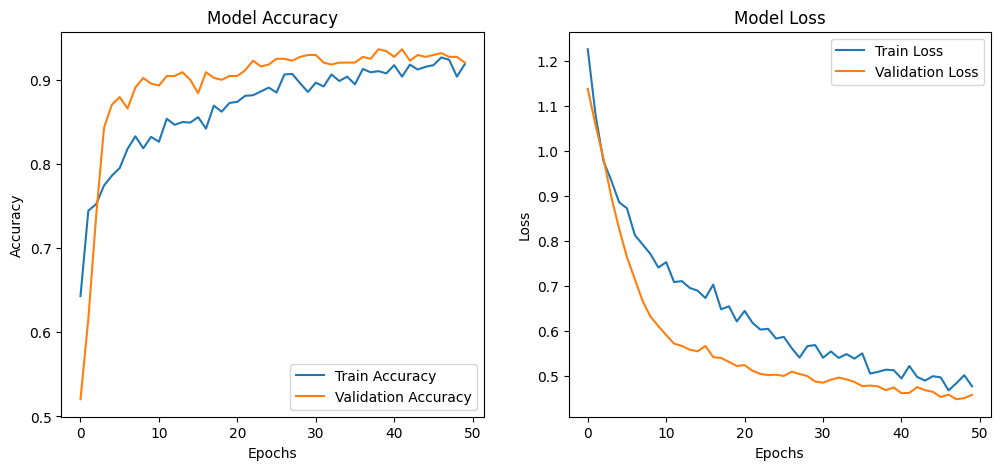

In [26]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [27]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze20_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.8880 - loss: 0.6094
Test Accuracy : 91.44%
Test Loss     : 0.535


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step


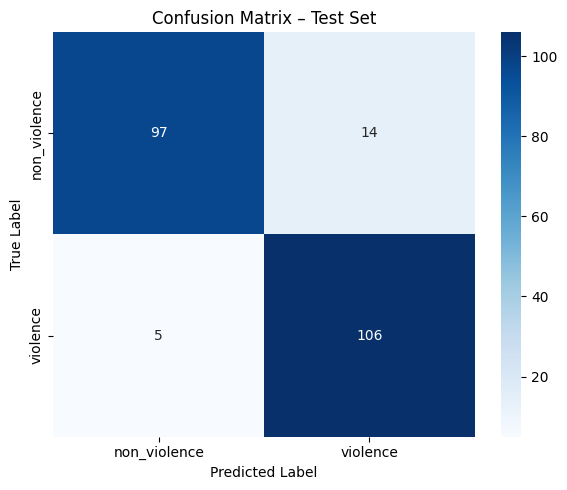


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.95      0.87      0.91       111
    violence       0.88      0.95      0.92       111

    accuracy                           0.91       222
   macro avg       0.92      0.91      0.91       222
weighted avg       0.92      0.91      0.91       222



In [28]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))